
# SVM Kernels post hoc explainer script 

This notebook is submitted in support of the main thesis' notebook.

Herein is a comparison of three kernels supplied with the relevant grid. Ultimately the linear kernel was chosen for having the best accuracy and $F_{1}$ scores amongst the three.


## Data Preparation and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import imblearn
import seaborn as sns

import math
import matplotlib.pyplot as plt
from inspect import signature
#set seed for reproducibility
np.random.seed(3896127045)

In [2]:
#Access the stata data file
df = pd.read_stata('ZA5931_v3-0-0.dta') 

Do not forget to attach the stata file 

In [3]:
#checking column indices to find indice of interest
{df.columns.get_loc(c):c for idx, c in enumerate(df.columns)} 

{0: 'studyno1',
 1: 'studyno2',
 2: 'doi',
 3: 'version',
 4: 'edition',
 5: 'survey',
 6: 'caseid',
 7: 'uniqid',
 8: 'serialid',
 9: 'tnscntry',
 10: 'country',
 11: 'isocntry',
 12: 'w1',
 13: 'de',
 14: 'w3',
 15: 'gb',
 16: 'w4',
 17: 'eu6',
 18: 'w5',
 19: 'eu9',
 20: 'w6',
 21: 'eu10',
 22: 'w7',
 23: 'eu12_1',
 24: 'w8',
 25: 'eu12_2',
 26: 'w9',
 27: 'eu_nms3',
 28: 'w10',
 29: 'eu15',
 30: 'w11',
 31: 'eu_nms10',
 32: 'w13',
 33: 'eu25',
 34: 'w14',
 35: 'euac2',
 36: 'w18',
 37: 'euac3',
 38: 'w15',
 39: 'eu27',
 40: 'w22',
 41: 'eu28',
 42: 'w23',
 43: 'eu_nms12',
 44: 'w24',
 45: 'euroz15',
 46: 'w29',
 47: 'euronz15',
 48: 'w30',
 49: 'euroz16',
 50: 'w81',
 51: 'euronz16',
 52: 'w82',
 53: 'euroz17',
 54: 'w89',
 55: 'eurnz17a',
 56: 'w90',
 57: 'eurnz17b',
 58: 'w93',
 59: 'euroz18',
 60: 'w98',
 61: 'eurnz18a',
 62: 'w99',
 63: 'eurnz18b',
 64: 'w83',
 65: 'eurnz18c',
 66: 'w84',
 67: 'eu_nms13',
 68: 'w94',
 69: 'cntrgr100',
 70: 'w100',
 71: 'wextra',
 72: 'q1_1',
 7

In [4]:
#Check Despriptives of target variables
df["qe1_1"].value_counts()

No, you have not donated in the past but you would be prepared to donate in the future        8591
No, you have not donated in the past and you would not be prepared to donate in the future    8251
Yes, you have donated in the past you and would be prepared to donate in the future           7238
Yes, you have donated in the past but you would not be prepared to donate in the future       3002
Name: qe1_1, dtype: int64

In [5]:
# Desriptives of demographic variables
df['d10'].value_counts()

Female    15588
Male      12280
Name: d10, dtype: int64

In [6]:
df['d11r1'].value_counts()

55 years and older    12401
40 - 54 years          6862
25 - 39 years          5964
15 - 24 years          2641
Name: d11r1, dtype: int64

In [7]:
df['d7r2'].value_counts()

(Re-)Married/Single with partner (1-8 in d7)    17765
Unmarried (9-10 in d7)                           4625
Widowed (13-14 in d7)                            2940
Divorced or separated (11-12 in d7)              2268
Other (SPONT.)                                    196
Name: d7r2, dtype: int64

In [8]:
# Subset the required columns into a new dataframe
df1 = df.iloc[0:,516: 676]
df1['tnscntry'] =df['tnscntry']
df1['d40t_r'] =df['d40t_r']
df1['d25'] =df['d25']
df1['d60'] =df['d60']

In [9]:
#Use Age to select respondents eligible for donating blood
ages = set(df1['d11'])
ages #checking out the odd figures


{'15 years',
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 '98 years',
 '99 years (and older)'}

In [10]:
# fixing the anomalies in the column
df1['d11'] = df1['d11'].replace('15 years', 15)
df1['d11'] = df1['d11'].replace('98 years', 98)
df1['d11'] = df1['d11'].replace('99 years (and older)',99)
df1['d11'] #check the corrected column

0        76
1        35
2        76
3        22
4        43
         ..
27863    29
27864    54
27865    29
27866    54
27867    54
Name: d11, Length: 27868, dtype: int64

In [11]:
#remove cases ineligible for donations because of age i.e. outside 15 to 70 years range
df1 = df1[df1['d11'] >= 15]
df1 = df1[df1['d11'] <= 70]


In [12]:
# check the noumber of observations to find your coverage on the sample after removing ineligible individuals
len(df1['d11'])

23488

In [13]:
# Check our dataframe again, this time to select our variables of interest
list(df1.columns.values)

['qe1_1',
 'qe1_2',
 'qe1_3',
 'qe1_4',
 'qe1_5',
 'qe1_6',
 'qe1t_1',
 'qe1t_2',
 'qe1t_3',
 'qe1t_4',
 'qe2_1',
 'qe2_2',
 'qe2_3',
 'qe2_4',
 'qe2t',
 'qe3_1',
 'qe3_2',
 'qe3_3',
 'qe3_4',
 'qe3_5',
 'qe3_6',
 'qe3_7',
 'qe4_1',
 'qe4_2',
 'qe4_3',
 'qe4_4',
 'qe4_5',
 'qe4_6',
 'qe4_7',
 'qe5a_1',
 'qe5a_2',
 'qe5a_3',
 'qe5a_4',
 'qe5a_5',
 'qe5a_6',
 'qe5a_7',
 'qe5a_8',
 'qe5a_9',
 'qe5a_10',
 'qe5b_1',
 'qe5b_2',
 'qe5b_3',
 'qe5b_4',
 'qe5b_5',
 'qe5b_6',
 'qe5b_7',
 'qe5b_8',
 'qe5b_9',
 'qe5b_10',
 'qe5b_11',
 'qe5b_12',
 'qe6_1',
 'qe6_2',
 'qe6_3',
 'qe6_4',
 'qe6_5',
 'qe6_6',
 'qe6_7',
 'qe6_8',
 'qe6_9',
 'qe6_10',
 'qe6_11',
 'qe6_12',
 'qe6t',
 'qe7_1',
 'qe7_2',
 'qe8_1',
 'qe8_2',
 'qe8_3',
 'qe8_4',
 'qe8_5',
 'qe8_6',
 'qe8_7',
 'qe8_8',
 'qe8_9',
 'qe8_10',
 'qe8_11',
 'qe9_1',
 'qe9_2',
 'qe9_3',
 'qe9_4',
 'qe9_5',
 'qe9_6',
 'qe9_7',
 'qe9_8',
 'qe9_9',
 'qe9_10',
 'qe9_11',
 'qe9_12',
 'qe9_13',
 'qe9t',
 'qe10_1',
 'qe10_2',
 'qe10_3',
 'qe10_4',
 'qe10_5',

In [14]:
#recode variables in the target to 0 and 1
df1['qe1_1'] =df1['qe1_1'].map({'No, you have not donated in the past and you would not be prepared to donate in the future': 0, 'Yes, you have donated in the past but you would not be prepared to donate in the future': 0,'No, you have not donated in the past but you would be prepared to donate in the future':1,'Yes, you have donated in the past you and would be prepared to donate in the future':1})
#Sort out the NaNs in the rest of the dataset
df1 = df1[['tnscntry','qe1_1','qe6_1','qe6_2','qe7_1','qe8_1','qe8_2','qe8_3','qe8_4','qe8_5','qe8_6','qe8_7','qe8_8','qe8_9','qe8_10','qe8_11','qe9_1','d1r1','d7r2','d11','d15a_r2','d25','d40t_r','d60', 'd61r','d63']]
df1.dropna()
#Deal with NAs/NaNs in the target
df1 = df1[np.isfinite(df1['qe1_1'])]
df1

,tnscntry,qe1_1,qe6_1,qe6_2,qe7_1,qe8_1,qe8_2,qe8_3,qe8_4,qe8_5,...,qe9_1,d1r1,d7r2,d11,d15a_r2,d25,d40t_r,d60,d61r,d63
1,BELGIQUE,1.0,Mentioned,Mentioned,"Yes, definitely",Not mentioned,Not mentioned,Mentioned,Not mentioned,Mentioned,...,Not mentioned,(7 -10) Right,Divorced or separated (11-12 in d7),35,Other white collars (13 or 14 in d15a),Rural area or village,Four or more,Almost never/never,Middel level (5-6 in d61),The middle class of society
3,BELGIQUE,1.0,Mentioned,Mentioned,"Yes, to some extent",Not mentioned,Mentioned,Mentioned,Not mentioned,Mentioned,...,Not mentioned,(5 - 6) Centre,Unmarried (9-10 in d7),22,Unemployed (3 in d15a),Rural area or village,Three,Most of the time,Low level (1-4 in d61),The middle class of society
4,BELGIQUE,0.0,Not mentioned,Not mentioned,"No, definitely not",Not mentioned,Not mentioned,Not mentioned,Not mentioned,Mentioned,...,Not mentioned,(7 -10) Right,(Re-)Married/Single with partner (1-8 in d7),43,Manual workers (15 to 18 in d15a),Large town,Four or more,From time to time,Middel level (5-6 in d61),The middle class of society
5,BELGIQUE,0.0,Not mentioned,Not mentioned,"Yes, to some extent",Not mentioned,Not mentioned,Not mentioned,Not mentioned,Not mentioned,...,Not mentioned,(5 - 6) Centre,Divorced or separated (11-12 in d7),48,Other white collars (13 or 14 in d15a),Large town,One,Almost never/never,Middel level (5-6 in d61),The middle class of society
7,BELGIQUE,0.0,Mentioned,Not mentioned,"No, not really",Not mentioned,Mentioned,Not mentioned,Not mentioned,Not mentioned,...,Not mentioned,(5 - 6) Centre,(Re-)Married/Single with partner (1-8 in d7),42,Other white collars (13 or 14 in d15a),Large town,Four or more,From time to time,High level (7-10 in d61),The middle class of society
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27863,HRVATSKA,1.0,Mentioned,Mentioned,"Yes, definitely",Not mentioned,Not mentioned,Not mentioned,Not mentioned,Not mentioned,...,Not mentioned,(1 - 4) Left,Unmarried (9-10 in d7),29,Self-employed (5 to 9 in d15a),Rural area or village,Four or more,From time to time,High level (7-10 in d61),The working class of society
27864,HRVATSKA,1.0,Mentioned,Mentioned,"Yes, to some extent",Not mentioned,Not mentioned,Mentioned,Not mentioned,Not mentioned,...,Not mentioned,NaN,(Re-)Married/Single with partner (1-8 in d7),54,Other white collars (13 or 14 in d15a),Small or middle sized town,Four or more,From time to time,Middel level (5-6 in d61),The middle class of society
27865,HRVATSKA,1.0,Mentioned,Mentioned,"Yes, to some extent",Not mentioned,Mentioned,Mentioned,Mentioned,Mentioned,...,Mentioned,(1 - 4) Left,(Re-)Married/Single with partner (1-8 in d7),29,Other white collars (13 or 14 in d15a),Small or middle sized town,Two,NaN,Low level (1-4 in d61),The working class of society
27866,HRVATSKA,0.0,Mentioned,Mentioned,"Yes, to some extent",Not mentioned,Mentioned,Not mentioned,Not mentioned,Not mentioned,...,Not mentioned,NaN,(Re-)Married/Single with partner (1-8 in d7),54,Unemployed (3 in d15a),Small or middle sized town,Three,From time to time,Middel level (5-6 in d61),The working class of society


In [15]:
#scale age
df1[['d11']] = df1[['d11']]/100
df1['d11']

1        0.35
3        0.22
4        0.43
5        0.48
7        0.42
         ... 
27863    0.29
27864    0.54
27865    0.29
27866    0.54
27867    0.54
Name: d11, Length: 22823, dtype: float64

In [16]:
#check the number of cases after dropping other NaNs
len(df1["qe1_1"])


22823

In [17]:
#Dummy code categorical variables
df1 = pd.get_dummies(df1)
df1

,qe1_1,d11,tnscntry_BELGIQUE,tnscntry_DANMARK,tnscntry_ELLADA,tnscntry_ESPANA,tnscntry_SUOMI,tnscntry_FRANCE,tnscntry_IRELAND,tnscntry_ITALIA,...,d60_From time to time,d60_Almost never/never,d61r_Low level (1-4 in d61),d61r_Middel level (5-6 in d61),d61r_High level (7-10 in d61),d63_The working class of society,d63_The middle class of society,d63_The upper class of society,d63_Other (SPONTANEOUS),d63_None (SPONTANEOUS)
1,1.0,0.35,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
3,1.0,0.22,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
4,0.0,0.43,1,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
5,0.0,0.48,1,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
7,0.0,0.42,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27863,1.0,0.29,0,0,0,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
27864,1.0,0.54,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,1,0,0,0
27865,1.0,0.29,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
27866,0.0,0.54,0,0,0,0,0,0,0,0,...,1,0,0,1,0,1,0,0,0,0


In [18]:
 list(df1.columns.values)

['qe1_1',
 'd11',
 'tnscntry_BELGIQUE',
 'tnscntry_DANMARK',
 'tnscntry_ELLADA',
 'tnscntry_ESPANA',
 'tnscntry_SUOMI',
 'tnscntry_FRANCE',
 'tnscntry_IRELAND',
 'tnscntry_ITALIA',
 'tnscntry_LUXEMBOURG',
 'tnscntry_NEDERLAND',
 'tnscntry_ÖSTERREICH',
 'tnscntry_PORTUGAL',
 'tnscntry_SVERIGE',
 'tnscntry_DEUTSCHLAND WEST',
 'tnscntry_DEUTSCHLAND OST',
 'tnscntry_GREAT BRITAIN',
 'tnscntry_NORTHERN IRELAND',
 'tnscntry_BALGARIJA',
 'tnscntry_KYPROS',
 'tnscntry_CESKA REPUBLIKA',
 'tnscntry_EESTI',
 'tnscntry_MAGYARORSZAG',
 'tnscntry_LATVIA',
 'tnscntry_LIETUVA',
 'tnscntry_MALTA',
 'tnscntry_POLSKA',
 'tnscntry_ROMANIA',
 'tnscntry_SLOVENSKA REPUBLIC',
 'tnscntry_SLOVENIJA',
 'tnscntry_HRVATSKA',
 'qe6_1_Not mentioned',
 'qe6_1_Mentioned',
 'qe6_2_Not mentioned',
 'qe6_2_Mentioned',
 'qe7_1_Yes, definitely',
 'qe7_1_Yes, to some extent',
 'qe7_1_No, not really',
 'qe7_1_No, definitely not',
 'qe8_1_Not mentioned',
 'qe8_1_Mentioned',
 'qe8_2_Not mentioned',
 'qe8_2_Mentioned',
 'qe8_3_

In [19]:
len(list(df1.columns.values))

98

In [20]:
#Create Country Subsets and split to train and test sets to retain proportions
from sklearn.model_selection import train_test_split
#Belgium
BELGIQUE_df1 = df1[df1.tnscntry_BELGIQUE == 1]
BELGIQUE_y = BELGIQUE_df1.pop('qe1_1')
BELGIQUE_X = BELGIQUE_df1
BELGIQUE_X_train, BELGIQUE_X_test, BELGIQUE_y_train, BELGIQUE_y_test = train_test_split(BELGIQUE_X, BELGIQUE_y, test_size= 0.20)
#Denmark
DANMARK_df1 = df1[df1.tnscntry_DANMARK == 1]
DANMARK_y = DANMARK_df1.pop('qe1_1')
DANMARK_X = DANMARK_df1
DANMARK_X_train, DANMARK_X_test, DANMARK_y_train, DANMARK_y_test = train_test_split(DANMARK_X, DANMARK_y, test_size= 0.20)

#Greece
ELLADA_df1 = df1[df1.tnscntry_ELLADA == 1]
ELLADA_y = ELLADA_df1.pop('qe1_1')
ELLADA_X = ELLADA_df1
ELLADA_X_train, ELLADA_X_test, ELLADA_y_train, ELLADA_y_test = train_test_split(ELLADA_X, ELLADA_y, test_size= 0.20)

#Spain

ESPANA_df1 = df1[df1.tnscntry_ESPANA == 1]
ESPANA_y = ESPANA_df1.pop('qe1_1')
ESPANA_X = ESPANA_df1
ESPANA_X_train, ESPANA_X_test, ESPANA_y_train, ESPANA_y_test = train_test_split(ESPANA_X, ESPANA_y, test_size= 0.20)

#Finland

SUOMI_df1 = df1[df1.tnscntry_SUOMI == 1]
SUOMI_y = SUOMI_df1.pop('qe1_1')
SUOMI_X = SUOMI_df1
SUOMI_X_train, SUOMI_X_test, SUOMI_y_train, SUOMI_y_test = train_test_split(SUOMI_X, SUOMI_y, test_size= 0.20)

#France

FRANCE_df1 = df1[df1.tnscntry_FRANCE == 1]
FRANCE_y = FRANCE_df1.pop('qe1_1')
FRANCE_X = FRANCE_df1
FRANCE_X_train, FRANCE_X_test, FRANCE_y_train, FRANCE_y_test = train_test_split(FRANCE_X, FRANCE_y, test_size= 0.20)


#Ireland

IRELAND_df1 = df1[df1.tnscntry_IRELAND == 1]
IRELAND_y = IRELAND_df1.pop('qe1_1')
IRELAND_X = IRELAND_df1
IRELAND_X_train, IRELAND_X_test, IRELAND_y_train, IRELAND_y_test = train_test_split(IRELAND_X, IRELAND_y, test_size= 0.20)


#Italy
ITALIA_df1 = df1[df1.tnscntry_ITALIA == 1]
ITALIA_y = ITALIA_df1.pop('qe1_1')
ITALIA_X = ITALIA_df1
ITALIA_X_train, ITALIA_X_test, ITALIA_y_train, ITALIA_y_test = train_test_split(ITALIA_X, ITALIA_y, test_size= 0.20)

#Luxembourg
LUXEMBOURG_df1 = df1[df1.tnscntry_LUXEMBOURG == 1]
LUXEMBOURG_y = LUXEMBOURG_df1.pop('qe1_1')
LUXEMBOURG_X = LUXEMBOURG_df1
LUXEMBOURG_X_train, LUXEMBOURG_X_test, LUXEMBOURG_y_train, LUXEMBOURG_y_test = train_test_split(LUXEMBOURG_X, LUXEMBOURG_y, test_size= 0.20)

#Netherlands
NEDERLAND_df1 = df1[df1.tnscntry_NEDERLAND == 1]
NEDERLAND_y = NEDERLAND_df1.pop('qe1_1')
NEDERLAND_X = NEDERLAND_df1
NEDERLAND_X_train, NEDERLAND_X_test, NEDERLAND_y_train, NEDERLAND_y_test = train_test_split(NEDERLAND_X, NEDERLAND_y, test_size= 0.20)

#Austria
ÖSTERREICH_df1 = df1[df1.tnscntry_ÖSTERREICH == 1]
ÖSTERREICH_y = ÖSTERREICH_df1.pop('qe1_1')
ÖSTERREICH_X = ÖSTERREICH_df1
ÖSTERREICH_X_train, ÖSTERREICH_X_test, ÖSTERREICH_y_train, ÖSTERREICH_y_test = train_test_split(ÖSTERREICH_X, ÖSTERREICH_y, test_size= 0.20)

#Portugal
PORTUGAL_df1 = df1[df1.tnscntry_PORTUGAL == 1]
PORTUGAL_y = PORTUGAL_df1.pop('qe1_1')
PORTUGAL_X = PORTUGAL_df1
PORTUGAL_X_train, PORTUGAL_X_test, PORTUGAL_y_train, PORTUGAL_y_test = train_test_split(PORTUGAL_X, PORTUGAL_y, test_size= 0.20)

#Sweden
SVERIGE_df1 = df1[df1.tnscntry_SVERIGE == 1]
SVERIGE_y = SVERIGE_df1.pop('qe1_1')
SVERIGE_X = SVERIGE_df1
SVERIGE_X_train, SVERIGE_X_test, SVERIGE_y_train, SVERIGE_y_test = train_test_split(SVERIGE_X, SVERIGE_y, test_size= 0.20)

#Germany (West part)
DEUTSCHLAND_WEST_df1 = df1[df1['tnscntry_DEUTSCHLAND WEST'] == 1]
DEUTSCHLAND_WEST_y = DEUTSCHLAND_WEST_df1.pop('qe1_1')
DEUTSCHLAND_WEST_X = DEUTSCHLAND_WEST_df1
DEUTSCHLAND_WEST_X_train, DEUTSCHLAND_WEST_X_test, DEUTSCHLAND_WEST_y_train, DEUTSCHLAND_WEST_y_test = train_test_split(DEUTSCHLAND_WEST_X, DEUTSCHLAND_WEST_y, test_size= 0.20)

#Germany (East part)
DEUTSCHLAND_OST_df1 = df1[df1['tnscntry_DEUTSCHLAND OST'] == 1]
DEUTSCHLAND_OST_y = DEUTSCHLAND_OST_df1.pop('qe1_1')
DEUTSCHLAND_OST_X = DEUTSCHLAND_OST_df1
DEUTSCHLAND_OST_X_train, DEUTSCHLAND_OST_X_test, DEUTSCHLAND_OST_y_train, DEUTSCHLAND_OST_y_test = train_test_split(DEUTSCHLAND_OST_X, DEUTSCHLAND_OST_y, test_size= 0.20)

#Great Britain
GREAT_BRITAIN_df1 = df1[df1['tnscntry_GREAT BRITAIN'] == 1]
GREAT_BRITAIN_y = GREAT_BRITAIN_df1.pop('qe1_1')
GREAT_BRITAIN_X = GREAT_BRITAIN_df1
GREAT_BRITAIN_X_train, GREAT_BRITAIN_X_test, GREAT_BRITAIN_y_train, GREAT_BRITAIN_y_test = train_test_split(GREAT_BRITAIN_X, GREAT_BRITAIN_y, test_size= 0.20)

#Northern Ireland

NORTHERN_IRELAND_df1 = df1[df1['tnscntry_NORTHERN IRELAND'] == 1]
NORTHERN_IRELAND_y = NORTHERN_IRELAND_df1.pop('qe1_1')
NORTHERN_IRELAND_X = NORTHERN_IRELAND_df1
NORTHERN_IRELAND_X_train, NORTHERN_IRELAND_X_test, NORTHERN_IRELAND_y_train, NORTHERN_IRELAND_y_test = train_test_split(NORTHERN_IRELAND_X, NORTHERN_IRELAND_y, test_size= 0.20)

#Bulagaria
BALGARIJA_df1 = df1[df1.tnscntry_BALGARIJA== 1]
BALGARIJA_y = BALGARIJA_df1.pop('qe1_1')
BALGARIJA_X = BALGARIJA_df1
BALGARIJA_X_train, BALGARIJA_X_test, BALGARIJA_y_train, BALGARIJA_y_test = train_test_split(BALGARIJA_X, BALGARIJA_y, test_size= 0.20)

#Cyprus
KYPROS_df1 = df1[df1.tnscntry_KYPROS == 1]
KYPROS_y = KYPROS_df1.pop('qe1_1')
KYPROS_X = KYPROS_df1
KYPROS_X_train, KYPROS_X_test, KYPROS_y_train, KYPROS_y_test = train_test_split(KYPROS_X, KYPROS_y, test_size= 0.20)

#Czechia

CESKA_REPUBLIKA_df1 = df1[df1['tnscntry_CESKA REPUBLIKA'] == 1]
CESKA_REPUBLIKA_y = CESKA_REPUBLIKA_df1.pop('qe1_1')
CESKA_REPUBLIKA_X = CESKA_REPUBLIKA_df1
CESKA_REPUBLIKA_X_train, CESKA_REPUBLIKA_X_test, CESKA_REPUBLIKA_y_train, CESKA_REPUBLIKA_y_test = train_test_split(CESKA_REPUBLIKA_X, CESKA_REPUBLIKA_y, test_size= 0.20)

#Estonia
EESTI_df1 = df1[df1.tnscntry_EESTI == 1]
EESTI_y = EESTI_df1.pop('qe1_1')
EESTI_X = EESTI_df1
EESTI_X_train, EESTI_X_test, EESTI_y_train, EESTI_y_test = train_test_split(EESTI_X, EESTI_y, test_size= 0.20)

#Hungary
MAGYARORSZAG_df1 = df1[df1.tnscntry_MAGYARORSZAG == 1]
MAGYARORSZAG_y = MAGYARORSZAG_df1.pop('qe1_1')
MAGYARORSZAG_X = MAGYARORSZAG_df1
MAGYARORSZAG_X_train, MAGYARORSZAG_X_test, MAGYARORSZAG_y_train, MAGYARORSZAG_y_test = train_test_split(MAGYARORSZAG_X, MAGYARORSZAG_y, test_size= 0.20)

#Latvia
LATVIA_df1 = df1[df1.tnscntry_LATVIA == 1]
LATVIA_y = LATVIA_df1.pop('qe1_1')
LATVIA_X = LATVIA_df1
LATVIA_X_train, LATVIA_X_test, LATVIA_y_train, LATVIA_y_test = train_test_split(LATVIA_X, LATVIA_y, test_size= 0.20)

#Lithuania
LIETUVA_df1 = df1[df1.tnscntry_LIETUVA == 1]
LIETUVA_y = LIETUVA_df1.pop('qe1_1')
LIETUVA_X = LIETUVA_df1
LIETUVA_X_train, LIETUVA_X_test, LIETUVA_y_train, LIETUVA_y_test = train_test_split(LIETUVA_X, LIETUVA_y, test_size= 0.20)

#Malta
MALTA_df1 = df1[df1.tnscntry_MALTA == 1]
MALTA_y = MALTA_df1.pop('qe1_1')
MALTA_X = MALTA_df1
MALTA_X_train, MALTA_X_test, MALTA_y_train, MALTA_y_test = train_test_split(MALTA_X, MALTA_y, test_size= 0.20)

#Poland
POLSKA_df1 = df1[df1.tnscntry_POLSKA == 1]
POLSKA_y = POLSKA_df1.pop('qe1_1')
POLSKA_X = POLSKA_df1
POLSKA_X_train, POLSKA_X_test, POLSKA_y_train, POLSKA_y_test = train_test_split(POLSKA_X, POLSKA_y, test_size= 0.20)

#Romania
ROMANIA_df1 = df1[df1.tnscntry_ROMANIA == 1]
ROMANIA_y = ROMANIA_df1.pop('qe1_1')
ROMANIA_X = ROMANIA_df1
ROMANIA_X_train, ROMANIA_X_test, ROMANIA_y_train, ROMANIA_y_test = train_test_split(ROMANIA_X, ROMANIA_y, test_size= 0.20)

#Slovakia
SLOVENSKA_REPUBLIC_df1 = df1[df1['tnscntry_SLOVENSKA REPUBLIC'] == 1]
SLOVENSKA_REPUBLIC_y = SLOVENSKA_REPUBLIC_df1.pop('qe1_1')
SLOVENSKA_REPUBLIC_X = SLOVENSKA_REPUBLIC_df1
SLOVENSKA_REPUBLIC_X_train, SLOVENSKA_REPUBLIC_X_test, SLOVENSKA_REPUBLIC_y_train, SLOVENSKA_REPUBLIC_y_test = train_test_split(SLOVENSKA_REPUBLIC_X, SLOVENSKA_REPUBLIC_y, test_size= 0.20)

#Slovenia
SLOVENIJA_df1 = df1[df1.tnscntry_SLOVENIJA == 1]
SLOVENIJA_y = SLOVENIJA_df1.pop('qe1_1')
SLOVENIJA_X = SLOVENIJA_df1
SLOVENIJA_X_train, SLOVENIJA_X_test, SLOVENIJA_y_train, SLOVENIJA_y_test = train_test_split(SLOVENIJA_X, SLOVENIJA_y, test_size= 0.20)

#Croatia
HRVATSKA_df1 = df1[df1.tnscntry_HRVATSKA == 1]
HRVATSKA_y = HRVATSKA_df1.pop('qe1_1')
HRVATSKA_X = HRVATSKA_df1
HRVATSKA_X_train, HRVATSKA_X_test, HRVATSKA_y_train, HRVATSKA_y_test = train_test_split(HRVATSKA_X, HRVATSKA_y, test_size= 0.20)


In [21]:
#Merge training sets
X_train = pd.concat([BELGIQUE_X_train, DANMARK_X_train,ELLADA_X_train, ESPANA_X_train, SUOMI_X_train, FRANCE_X_train, IRELAND_X_train, ITALIA_X_train,LUXEMBOURG_X_train, NEDERLAND_X_train, ÖSTERREICH_X_train, PORTUGAL_X_train, SVERIGE_X_train, DEUTSCHLAND_WEST_X_train, DEUTSCHLAND_OST_X_train, GREAT_BRITAIN_X_train, NORTHERN_IRELAND_X_train, BALGARIJA_X_train, KYPROS_X_train, CESKA_REPUBLIKA_X_train, EESTI_X_train, MAGYARORSZAG_X_train, LATVIA_X_train, LIETUVA_X_train, MALTA_X_train, POLSKA_X_train, ROMANIA_X_train, SLOVENSKA_REPUBLIC_X_train, SLOVENIJA_X_train, HRVATSKA_X_train])
y_train = pd.concat([BELGIQUE_y_train, DANMARK_y_train,ELLADA_y_train, ESPANA_y_train, SUOMI_y_train, FRANCE_y_train, IRELAND_y_train, ITALIA_y_train,LUXEMBOURG_y_train, NEDERLAND_y_train, ÖSTERREICH_y_train, PORTUGAL_y_train, SVERIGE_y_train, DEUTSCHLAND_WEST_y_train, DEUTSCHLAND_OST_y_train, GREAT_BRITAIN_y_train, NORTHERN_IRELAND_y_train, BALGARIJA_y_train, KYPROS_y_train, CESKA_REPUBLIKA_y_train, EESTI_y_train, MAGYARORSZAG_y_train, LATVIA_y_train, LIETUVA_y_train, MALTA_y_train, POLSKA_y_train, ROMANIA_y_train, SLOVENSKA_REPUBLIC_y_train, SLOVENIJA_y_train, HRVATSKA_y_train])



In [22]:
# Merging test sets
X_test = pd.concat([BELGIQUE_X_test, DANMARK_X_test,ELLADA_X_test, ESPANA_X_test, SUOMI_X_test, FRANCE_X_test, IRELAND_X_test, ITALIA_X_test,LUXEMBOURG_X_test, NEDERLAND_X_test, ÖSTERREICH_X_test, PORTUGAL_X_test, SVERIGE_X_test, DEUTSCHLAND_WEST_X_test, DEUTSCHLAND_OST_X_test, GREAT_BRITAIN_X_test, NORTHERN_IRELAND_X_test, BALGARIJA_X_test, KYPROS_X_test, CESKA_REPUBLIKA_X_test, EESTI_X_test, MAGYARORSZAG_X_test, LATVIA_X_test, LIETUVA_X_test, MALTA_X_test, POLSKA_X_test, ROMANIA_X_test,SLOVENSKA_REPUBLIC_X_test, SLOVENIJA_X_test, HRVATSKA_X_test])
y_test = pd.concat([BELGIQUE_y_test, DANMARK_y_test,ELLADA_y_test, ESPANA_y_test, SUOMI_y_test, FRANCE_y_test, IRELAND_y_test, ITALIA_y_test,LUXEMBOURG_y_test, NEDERLAND_y_test, ÖSTERREICH_y_test, PORTUGAL_y_test, SVERIGE_y_test, DEUTSCHLAND_WEST_y_test, DEUTSCHLAND_OST_y_test, GREAT_BRITAIN_y_test, NORTHERN_IRELAND_y_test, BALGARIJA_y_test, KYPROS_y_test, CESKA_REPUBLIKA_y_test, EESTI_y_test, MAGYARORSZAG_y_test, LATVIA_y_test, LIETUVA_y_test, MALTA_y_test, POLSKA_y_test, ROMANIA_y_test, SLOVENSKA_REPUBLIC_y_test, SLOVENIJA_y_test, HRVATSKA_y_test])

In [23]:
# Checking the 80/20 (a ratio of 4:1 or sufficiently close)split ratio in the merged train and test sets
len(X_train)/len(X_test)

3.9886338797814207

In [24]:
# Check for class imbalance

df1["qe1_1"].value_counts()

1.0    14426
0.0     8397
Name: qe1_1, dtype: int64

In [25]:
#Apply SMOTE to balance the data
from imblearn.over_sampling import SMOTE
sm = SMOTE() 
X_train_res, y_train_res = sm.fit_sample(X_train, y_train.ravel()) 

In [26]:
train_labels = pd.DataFrame(y_train_res)
train_labels[0].value_counts()

1.0    11512
0.0    11512
Name: 0, dtype: int64

In [27]:
{X_train_res.columns.get_loc(c):c for idx, c in enumerate(X_train_res.columns)}

{0: 'd11',
 1: 'tnscntry_BELGIQUE',
 2: 'tnscntry_DANMARK',
 3: 'tnscntry_ELLADA',
 4: 'tnscntry_ESPANA',
 5: 'tnscntry_SUOMI',
 6: 'tnscntry_FRANCE',
 7: 'tnscntry_IRELAND',
 8: 'tnscntry_ITALIA',
 9: 'tnscntry_LUXEMBOURG',
 10: 'tnscntry_NEDERLAND',
 11: 'tnscntry_ÖSTERREICH',
 12: 'tnscntry_PORTUGAL',
 13: 'tnscntry_SVERIGE',
 14: 'tnscntry_DEUTSCHLAND WEST',
 15: 'tnscntry_DEUTSCHLAND OST',
 16: 'tnscntry_GREAT BRITAIN',
 17: 'tnscntry_NORTHERN IRELAND',
 18: 'tnscntry_BALGARIJA',
 19: 'tnscntry_KYPROS',
 20: 'tnscntry_CESKA REPUBLIKA',
 21: 'tnscntry_EESTI',
 22: 'tnscntry_MAGYARORSZAG',
 23: 'tnscntry_LATVIA',
 24: 'tnscntry_LIETUVA',
 25: 'tnscntry_MALTA',
 26: 'tnscntry_POLSKA',
 27: 'tnscntry_ROMANIA',
 28: 'tnscntry_SLOVENSKA REPUBLIC',
 29: 'tnscntry_SLOVENIJA',
 30: 'tnscntry_HRVATSKA',
 31: 'qe6_1_Not mentioned',
 32: 'qe6_1_Mentioned',
 33: 'qe6_2_Not mentioned',
 34: 'qe6_2_Mentioned',
 35: 'qe7_1_Yes, definitely',
 36: 'qe7_1_Yes, to some extent',
 37: 'qe7_1_No, not re

In [28]:
#Drop countries, assumed similiraity  means we cannot use them as a predictor of willingness
idx = np.r_[1:31]
X_train_res.drop(X_train_res.columns[idx], axis=1, inplace=True)
X_train_res

,d11,qe6_1_Not mentioned,qe6_1_Mentioned,qe6_2_Not mentioned,qe6_2_Mentioned,"qe7_1_Yes, definitely","qe7_1_Yes, to some extent","qe7_1_No, not really","qe7_1_No, definitely not",qe8_1_Not mentioned,...,d60_From time to time,d60_Almost never/never,d61r_Low level (1-4 in d61),d61r_Middel level (5-6 in d61),d61r_High level (7-10 in d61),d63_The working class of society,d63_The middle class of society,d63_The upper class of society,d63_Other (SPONTANEOUS),d63_None (SPONTANEOUS)
0,0.150000,0,1,0,1,1,0,0,0,1,...,0,1,0,1,0,0,1,0,0,0
1,0.370000,0,1,1,0,0,1,0,0,1,...,0,1,0,1,0,0,1,0,0,0
2,0.640000,0,1,1,0,0,0,1,0,1,...,0,1,0,0,1,0,1,0,0,0
3,0.550000,1,0,1,0,0,1,0,0,1,...,1,0,0,0,1,0,1,0,0,0
4,0.510000,1,0,1,0,0,0,0,1,1,...,0,0,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23019,0.630956,0,1,0,1,1,0,0,0,1,...,0,1,0,1,0,0,1,0,0,0
23020,0.211879,0,1,1,0,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
23021,0.324628,0,1,0,1,0,1,0,0,1,...,0,0,0,1,0,0,1,0,0,0
23022,0.260000,0,1,1,0,0,1,0,0,1,...,0,0,0,1,0,0,1,0,0,0


## Apply Algorithms

## Fix test set for algorithms

We drop the country variables in the test and re-attach them later.

In [29]:
# save countries to a separate dataframe
test_countries = X_test.iloc[:, 1:31] 

# drop countries in test data
idx = np.r_[1:31]
X_test.drop(X_test.columns[idx], axis=1, inplace=True)
X_test

,d11,qe6_1_Not mentioned,qe6_1_Mentioned,qe6_2_Not mentioned,qe6_2_Mentioned,"qe7_1_Yes, definitely","qe7_1_Yes, to some extent","qe7_1_No, not really","qe7_1_No, definitely not",qe8_1_Not mentioned,...,d60_From time to time,d60_Almost never/never,d61r_Low level (1-4 in d61),d61r_Middel level (5-6 in d61),d61r_High level (7-10 in d61),d63_The working class of society,d63_The middle class of society,d63_The upper class of society,d63_Other (SPONTANEOUS),d63_None (SPONTANEOUS)
661,0.20,0,1,1,0,1,0,0,0,1,...,0,1,0,1,0,0,1,0,0,0
692,0.38,0,1,0,1,0,1,0,0,1,...,0,1,0,0,1,0,1,0,0,0
308,0.31,0,1,0,1,0,0,0,0,1,...,0,1,0,1,0,1,0,0,0,0
450,0.56,0,1,0,1,1,0,0,0,1,...,0,0,0,1,0,0,1,0,0,0
871,0.66,0,1,0,1,1,0,0,0,1,...,0,1,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27415,0.69,1,0,1,0,0,1,0,0,1,...,0,1,0,0,1,0,1,0,0,0
27013,0.44,0,1,0,1,1,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0
26834,0.47,0,1,0,1,0,1,0,0,1,...,1,0,0,1,0,1,0,0,0,0
27777,0.42,0,1,1,0,1,0,0,0,1,...,0,1,0,1,0,0,1,0,0,0


### Apply SVM and Random Forest

We will not place the algorithms in one grid (as is demanded by efficiency). There is need to evaluate the performance of the best of each classifier's grid.

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 17.3min
C:\Users\tjfus\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 53.5min finished


Best Parameters:  {'classifier': SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=1, kernel='rbf', max_iter=-1,
    probability=False, random_state=None, shrinking=True, tol=0.001,
    verbose=False), 'classifier__C': 1, 'classifier__gamma': 1, 'classifier__kernel': 'rbf'}
Best Estimator:  Pipeline(memory=None,
         steps=[('classifier',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=1, kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)
              precision    recall  f1-score   support

         0.0       0.56      0.20      0.29      1661
         1.0       0.67      0.91      0.77      2914

    accuracy                           0.65      4575
   ma

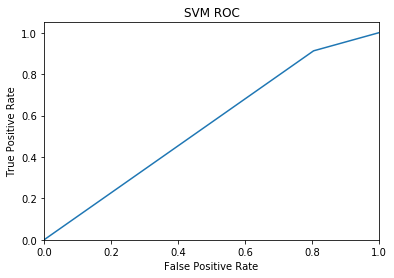

<Figure size 432x288 with 0 Axes>

In [30]:
#SVM RBF
from matplotlib.pyplot import savefig
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix as confusion_matrix
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# Create first pipeline for base without reducing features.

pipe = Pipeline([('classifier' , svm.SVC(gamma= 'auto'))])
# pipe = Pipeline([('classifier', RandomForestClassifier())])

# Create param grid.

param_grid = [
    {'classifier' : [svm.SVC()],
     'classifier__C' :  [0.1, 0.25, 0.5, 1],
    'classifier__gamma' : [0.01, 0.1, 1, 5, 10],
    'classifier__kernel': ['rbf']}
]

# Create grid search object

svm_select = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)


# Fit on data, and find best parameter and estimator

best_svm_select = svm_select.fit(X_train_res, y_train_res)

print("Best Parameters: ",best_svm_select.best_params_)
print("Best Estimator: ",best_svm_select.best_estimator_)
# Predict test values

svm_pred = best_svm_select.predict(X_test)

#Evaluate SVM Classifier performance

print(classification_report(y_test, svm_pred))
print(accuracy_score(y_test, svm_pred))

#Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, svm_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("Area under the curve: ",roc_auc_score(y_test, svm_pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC')
plt.show()
savefig('SVM ROC', format= 'png')

The accuracy on the the test slightly higher than that for the majority baseline. However the F1 score is lowe. we move to the next kernel.

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 20.4min
C:\Users\tjfus\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\tjfus\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\tjfus\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\tjfus\Anacond

Best Parameters:  {'classifier': SVC(C=1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 1, 'classifier__gamma': 0.01, 'classifier__kernel': 'sigmoid'}
Best Estimator:  Pipeline(memory=None,
         steps=[('classifier',
                 SVC(C=1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.01, kernel='sigmoid', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
              precision    recall  f1-score   support

         0.0       0.60      0.47      0.53      1661
         1.0       0.73      0.82      0.77      2914

    accuracy                          

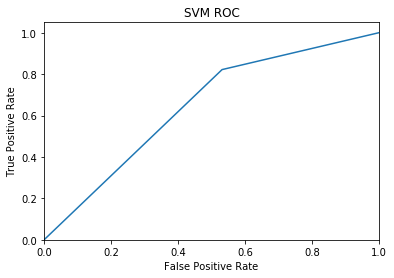

<Figure size 432x288 with 0 Axes>

In [31]:
#SVM Sigmoid


# Create param grid.

param_grid = [
    {'classifier' : [svm.SVC()],
     'classifier__C' :  [0.1, 0.25, 0.5, 1],
    'classifier__gamma' : [0.01, 0.1, 1, 5, 10],
    'classifier__kernel': ['sigmoid']}
]

# Create grid search object

svm_select = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)


# Fit on data, and find best parameter and estimator

best_svm_select = svm_select.fit(X_train_res, y_train_res)

print("Best Parameters: ",best_svm_select.best_params_)
print("Best Estimator: ",best_svm_select.best_estimator_)
# Predict test values

svm_pred = best_svm_select.predict(X_test)

#Evaluate SVM Classifier performance

print(classification_report(y_test, svm_pred))
print(accuracy_score(y_test, svm_pred))

#Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, svm_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("Area under the curve: ",roc_auc_score(y_test, svm_pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC')
plt.show()
savefig('SVM ROC', format= 'png')

The accuracy has improved but the $F_{1}$  score has not. we now consider the next kernel. 

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.7min
C:\Users\tjfus\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\Users\tjfus\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 39.9min finished


Best Parameters:  {'classifier': SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False), 'classifier__C': 0.1, 'classifier__gamma': 0.01, 'classifier__kernel': 'linear'}
Best Estimator:  Pipeline(memory=None,
         steps=[('classifier',
                 SVC(C=0.1, break_ties=False, cache_size=200, class_weight=None,
                     coef0=0.0, decision_function_shape='ovr', degree=3,
                     gamma=0.01, kernel='linear', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)
              precision    recall  f1-score   support

         0.0       0.62      0.41      0.50      1661
         1.0       0.72      0.86      0.78      2914

    accuracy                       

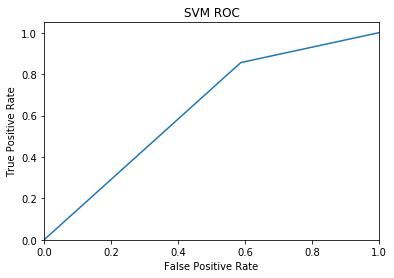

<Figure size 432x288 with 0 Axes>

In [32]:
#SVM Linear

# Create param grid.

param_grid = [
    {'classifier' : [svm.SVC()],
     'classifier__C' :  [0.1, 0.25, 0.5, 1],
    'classifier__gamma' : [0.01, 0.1, 1, 5, 10],
    'classifier__kernel': ['linear']}
]

# Create grid search object

svm_select = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)


# Fit on data, and find best parameter and estimator

best_svm_select = svm_select.fit(X_train_res, y_train_res)

print("Best Parameters: ",best_svm_select.best_params_)
print("Best Estimator: ",best_svm_select.best_estimator_)
# Predict test values

svm_pred = best_svm_select.predict(X_test)

#Evaluate SVM Classifier performance

print(classification_report(y_test, svm_pred))
print(accuracy_score(y_test, svm_pred))

#Plot ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_test, svm_pred)
    roc_auc[i] = auc(fpr[i], tpr[i])

print("Area under the curve: ",roc_auc_score(y_test, svm_pred))
plt.figure()
plt.plot(fpr[1], tpr[1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM ROC')
plt.show()
savefig('SVM ROC', format= 'png')

In this case the accuracy is better than for the majority baseline and their $F_{1}$ scores are at par. so we consider the grid solution under the linear kernel as our current best estimator.